# Plots 

> Defines some circadian data science plots, like actograms

In [ ]:
# | default_exp plots


In [ ]:
# | hide
from nbdev.showdoc import *


In [ ]:
# | export

from scipy.ndimage import gaussian_filter1d
from copy import deepcopy
import pylab as plt
import numpy as np
from pathlib import Path
import sys
from circadian.utils import cut_phases_12
from circadian.models import SinglePopModel
from circadian.lights import *


## Actograms



In [ ]:
# | export

class Actogram:

    def __init__(self,
                 time_total: np.ndarray, # time in hours
                 light_vals: np.ndarray, # light values or proxy should be the same length as time_total
                 second_zeit: np.ndarray = None, # optional second zeitgeber to show on the right side
                 ax=None, # Axis to plot on, if None a new figure is created
                 threshold=10.0, # threshold for light on/off 
                 threshold2=None, # threshold for light on/off for second zeitgeber
                 opacity: float = 1.0, # opacity of the light on/off rectangles
                 color: str = 'black', # color of the light on/off rectangles, for the below threshold values
                 smooth=True, # whether to apply a gaussian filter to the light values to smooth it, useful for wearable data
                 sigma=[2.0, 2.0], # sigma for the gaussian filter
                 *args, # additional plot arguments
                 **kwargs # additional plot keyword arguments
                 ):

        self.time_total = time_total
        self.light_vals = light_vals
        self.num_days = np.ceil((time_total[-1] - time_total[0])/24.0)

        self.second_zeit = second_zeit if second_zeit is not None else light_vals

        if smooth:
            self.light_vals = gaussian_filter1d(
                self.light_vals, sigma=sigma[0])
            self.second_zeit = gaussian_filter1d(
                self.second_zeit, sigma=sigma[1])

        threshold2 = threshold if threshold2 is None else threshold2
        self.ax = ax if ax is not None else plt.gca()

        # Set graphical parameters
        label_scale = int(np.floor(self.num_days/30))
        if label_scale < 1:
            label_scale = 1

        self.opacity = opacity
        self.darkColor = color
        start_day = np.floor(self.time_total[0]/24.0)
        self.ax.set_ylim(start_day, self.num_days+start_day)
        self.ax.set_xlim(0, 48)
        self.ax.set_yticks(
            np.arange(int(start_day), self.num_days+1+start_day, label_scale))
        ylabels_list = list(range(int(start_day), int(
            self.num_days+start_day)+1, label_scale))
        # ylabels_list.reverse()

        self.ax.set_yticklabels(ylabels_list)
        self.ax.set_xticks(np.arange(0, 48+3, 3))
        xlabels_list = list(range(0, 27, 3))+list(range(3, 27, 3))
        self.ax.set_xticklabels(xlabels_list)
        self.ax.set_xticks(np.arange(0, 48, 1), minor=True)

        #self.ax.yaxis.grid(False, linewidth=1.0, color='k')
        # self.ax.xaxis.grid(False)

        self.ax.plot(24.0*np.ones(100), 
                     np.linspace(0, self.num_days,100), 
                     ls='--', 
                     lw=2.0, 
                     color='black', 
                     zorder=9)
        self.ax.set_xlabel("ZT")
        self.ax.set_ylabel("Days")

        self.addLightSchedule(self.light_vals, threshold,
                              plt_option='left', color=self.darkColor)
        self.addLightSchedule(self.second_zeit, threshold2,
                              plt_option='right', color=self.darkColor)
        self.ax.invert_yaxis()

    def getRectangles(self, timeon, timeoff, colorIn='white'):
        bottom_x = np.fmod(timeon, 24.0)
        bottom_y = int(timeon/24.0)  # -1
        alpha = self.opacity if colorIn != 'white' else 0.0
        r1 = plt.Rectangle((bottom_x, bottom_y), timeoff -
                           timeon, 1, fc=colorIn, zorder=-1, alpha=alpha)
        r2 = plt.Rectangle((bottom_x+24.0, bottom_y),
                           timeoff-timeon, 1, fc=colorIn, zorder=1, alpha=alpha)
        return((r1, r2))

    def addRect(self, timeon, timeoff, colorIn='white', plt_option='both'):
        """Used to add a rectangle to the axes"""
        r = self.getRectangles(timeon, timeoff, colorIn)
        if plt_option == 'left':
            self.ax.add_patch(r[0])
            return
        if plt_option == 'right':
            self.ax.add_patch(r[1])
            return
        self.ax.add_patch(r[0])
        self.ax.add_patch(r[1])

    def addLightSchedule(self, zeit: np.ndarray,
                         threshold: float,
                         plt_option: str = 'both',
                         color='black'):
        lightdata = zeit
        timedata = self.time_total
        lightsOn = False
        if (lightdata[0] > threshold):
            lightsOn = True
            lightStart = timedata[0]
        else:
            darkOn = True
            darkStart = timedata[0]

        dayCounter = int(timedata[0]/24.0)  # count the days in the data set
        for i in range(1, len(lightdata)):
            currentDay = int(timedata[i]/24.0)
            if (currentDay != dayCounter):
                dayCounter = currentDay
                if (lightsOn == True):
                    self.addRect(
                        lightStart, timedata[i], plt_option=plt_option)
                    if (i+1 < len(timedata)):
                        # reset the light counter to start over the next day
                        lightStart = timedata[i+1]
                else:
                    self.addRect(
                        darkStart, timedata[i], colorIn=color, plt_option=plt_option)
                    if (i+1 < len(timedata)):
                        darkStart = timedata[i+1]

            if (lightdata[i] < threshold and lightsOn == True):
                self.addRect(lightStart, timedata[i-1], plt_option=plt_option)
                lightsOn = False
                darkOn = True
                darkStart = timedata[i]
            if (lightsOn == False and lightdata[i] >= threshold):
                lightsOn = True
                lightStart = timedata[i]
                darkOn = False
                self.addRect(
                    darkStart, timedata[i-1], colorIn=color, plt_option=plt_option)

    def plot_phasemarker(self, phase_marker_times: np.ndarray,
                         error: np.ndarray = None,
                         alpha=1.0,
                         alpha_error=0.30,
                         scatter=False,
                         *args, **kwargs):
        """
        This method takes in a list of times which are assumed to occur at the same 
        circadian phase (e.g. DLMO, CBTmin). These are plotted as points 
        on the actogram.  
            plot_phasemarker(self, phase_marker_times: np.ndarray, *args, **kwargs)
        """

        xvals = deepcopy(phase_marker_times)
        yvals = deepcopy(phase_marker_times)

        xvals = np.fmod(xvals, 24.0)
        yvals = np.floor(yvals / 24.0) + 0.5

        if scatter:
            self.ax.scatter(xvals, yvals, *args, **kwargs)
            self.ax.scatter(xvals+24.0, yvals, *args, **kwargs)

        idx_split = (np.absolute(np.diff(xvals)) > 6.0).nonzero()[0]+1
        xvals_split = np.split(xvals, idx_split)
        yvals_split = np.split(yvals, idx_split)
        if error is not None:
            error_split = np.split(error, idx_split)

        for (idx, xx) in enumerate(xvals_split):
            self.ax.plot(xx, yvals_split[idx], alpha=alpha, *args, **kwargs)
            self.ax.plot(
                xx+24.0, yvals_split[idx], alpha=alpha, *args, **kwargs)
            if error is not None:
                self.ax.fill_betweenx(
                    yvals_split[idx], xx-error_split[idx], xx+error_split[idx], alpha=alpha_error, *args, **kwargs)
                self.ax.fill_betweenx(
                    yvals_split[idx], xx-error_split[idx]+24.0, xx+error_split[idx]+24.0, alpha=alpha_error, *args, **kwargs)

    def plot_phasetimes(self, times: np.ndarray, phases: np.ndarray, error: np.ndarray = None,
                        alpha_error=0.30, alpha=1.0, *args, **kwargs):
        """
            This method takes observations of the phase and times (same length arrays)
            and adds them to the actogram.    

            plot_phasetimes(self, times: np.ndarray, phases: np.ndarray, *args, **kwargs)
        """
        xvals = deepcopy(phases)
        xvals = np.arctan2(np.sin(xvals), np.cos(xvals))
        for i in range(len(xvals)):
            if xvals[i] < 0.0:
                xvals[i] += 2*np.pi

        xvals = np.fmod(xvals, 2*np.pi)
        xvals *= 12.0/np.pi

        xvals = np.fmod(xvals, 24.0)
        yvals = deepcopy(times)
        yvals = np.floor(yvals / 24.0) + 0.5

        idx_split = (np.absolute(np.diff(xvals)) > 6.0).nonzero()[0]+1
        xvals_split = np.split(xvals, idx_split)
        yvals_split = np.split(yvals, idx_split)
        if error is not None:
            error_split = np.split(error, idx_split)

        for (idx, xx) in enumerate(xvals_split):
            self.ax.plot(xx, yvals_split[idx], alpha=alpha, *args, **kwargs)
            self.ax.plot(
                xx+24.0, yvals_split[idx], alpha=alpha, *args, **kwargs)
            if error is not None:
                self.ax.fill_betweenx(
                    yvals_split[idx], xx-error_split[idx], xx+error_split[idx], alpha=alpha_error, *args, **kwargs)
                self.ax.fill_betweenx(
                    yvals_split[idx], xx-error_split[idx]+24.0, xx+error_split[idx]+24.0, alpha=alpha_error, *args, **kwargs)



In [ ]:
#| export 

def plot_mae(dlmo_actual: np.ndarray,  # expected to be in hours
             dlmo_pred: np.ndarray,  # predicted to be in hours
             norm_to: float = None, 
             ax=None,  
             *args, 
             **kwargs):

    dlmo_actual = np.fmod(dlmo_actual, 24.0)
    dlmo_pred = np.fmod(dlmo_pred, 24.0)

    # Make the plot range from from -12 to 12
    dlmo_pred = np.array([cut_phases_12(d) for d in list(dlmo_pred)])
    dlmo_actual = np.array([cut_phases_12(d) for d in list(dlmo_actual)])

    if norm_to is not None:
        dlmo_actual = dlmo_actual - np.mean(dlmo_actual)+norm_to

    if ax is None:
        plt.figure()
        ax = plt.gca()

    errors = dlmo_pred-dlmo_actual
    print(f"The MAE is: {np.mean(abs(errors))}")
    print(f"Within one hour {np.sum(abs(errors)<=1.0)}/{len(dlmo_pred)}")
    print(errors)

    ax.scatter(dlmo_actual, dlmo_pred, *args, **kwargs)
    ax.plot(np.arange(-12, 12, 1), np.arange(-12, 12, 1),
            ls='--', color='gray', lw=2.0)
    ax.plot(np.arange(-12, 12, 1), np.arange(-12, 12, 1)+1,
            ls='--', color='blue', lw=1.0)
    ax.plot(np.arange(-12, 12, 1), np.arange(-12, 12, 1)-1,
            ls='--', color='blue', lw=1.0)

    ax.set_ylabel("Model Prediction (hrs)")
    ax.set_xlabel("Experimental DLMO (hrs)")



In [ ]:
 #| export
 
 
def plot_torus(phase1: np.ndarray, phase2: np.ndarray, scale24=False, ax=None, *args, **kwargs):

    if ax is None:
        plt.figure()
        ax = plt.gca()

    if scale24:
        phase1 = np.fmod(phase1, 24.0) * np.pi/12.0
        phase2 = np.fmod(phase2,  24.0) * np.pi/24.0

    phase1 = np.arctan2(np.sin(phase1), np.cos(phase1))
    phase2 = np.arctan2(np.sin(phase2), np.cos(phase2))

    ax.scatter(phase1, phase2, *args, **kwargs)


Example of an actogram

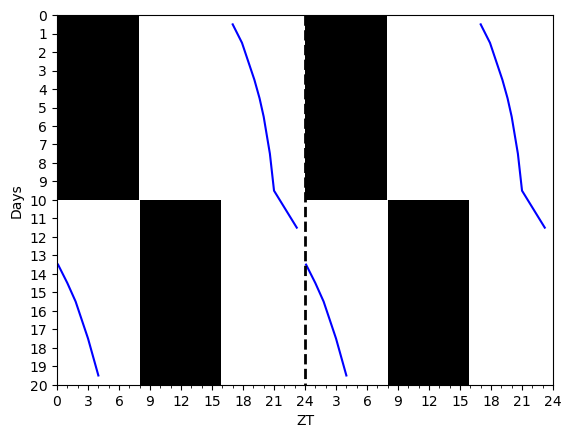

In [ ]:
slam_shift = Light.SlamShift() 
ts = np.arange(0, 20*24.0, 0.10)
light_values = slam_shift(ts) 

act = Actogram(ts, light_vals=light_values, smooth=False)
spm = SinglePopModel()

trajectory = spm(ts, light_values, np.array([1.0, np.pi, 0.0]))
dlmo = spm.dlmos(trajectory=trajectory)

act.plot_phasemarker(dlmo, color='blue')
plt.show()


In [ ]:
# | export

class Stroboscopic:
    """
    This class can be used to make a stroboscopic plot of the entrainment of an oscillator to a sudden shift in schedule
    """

    def __init__(self, 
                 ax: plt.Axes,
                 ts: np.ndarray,
                amplitude: np.ndarray,
                phase: np.ndarray,
                period: float = 24.0, # The time period between stroboscopic arrows
                *args: tuple, #passed to the quiver plot
                **kwargs: dict #passed to the quiver plot
        ):
        """
        Pass in axes and a time series data frame for the model. Make sure to pass the pandas data frame starting with 
        the row you want to begin the stroboscopic plot
        """
        self.ts = ts
        self.R = amplitude
        self.phase = phase
        self.period = period
        self.ax = ax

        self._make_strobo_plot(*args, **kwargs)

    def _make_strobo_plot(self, *args, **kwargs):
        """Add the paths to a quiver plot"""
        start_amp = self.R[0]

        Xvals = np.array(self.R / start_amp * np.cos(self.phase))
        Yvals = np.array(self.R / start_amp * np.sin(self.phase))

        circle_angles = np.linspace(0, 2 * np.pi, 1000)
        circle_x = list([np.cos(x) for x in circle_angles])
        circle_y = list([np.sin(x) for x in circle_angles])

        self.ax.plot(circle_x, circle_y, lw=2.0, color='k')
        # Sample down to every 24 hours
        Xvals = np.interp(np.arange(self.ts[0], self.ts[-1], self.period), self.ts, Xvals)
        Yvals = np.interp(np.arange(self.ts[0], self.ts[-1], self.period), self.ts, Yvals)
        upper_bound = len(Xvals)
        for i in range(1, upper_bound):
            self.ax.quiver(Xvals[i - 1], Yvals[i - 1], Xvals[i] - Xvals[i - 1], Yvals[i] - Yvals[i - 1],
                           scale_units='xy', angles='xy', scale=1, *args, **kwargs)
        self.ax.set_xlim([-1.1, 1.1])
        self.ax.set_ylim([-1.1, 1.1])
        self.ax.scatter([0.0], [0.0], color='k')
        self.ax.set_axis_off()

    def add_strobo_plot(self, 
                        amplitude: np.ndarray,
                        phase: np.ndarray,
                        col='darkgreen'):
        """Add a strobo plot to the axes for comparison"""
        start_amp = amplitude[0]

        Xvals = np.array(amplitude / start_amp * np.cos(phase))
        Yvals = np.array(amplitude / start_amp * np.sin(phase))

        # Sample down to every 24 hours
        Xvals = Xvals[::240]
        Yvals = Yvals[::240]

        upper_bound = min(10, len(Xvals))
        for i in range(1, upper_bound + 10):
            self.ax.quiver(Xvals[i - 1], Yvals[i - 1], Xvals[i] - Xvals[i - 1], Yvals[i] - Yvals[i - 1],
                           scale_units='xy', angles='xy', scale=1, color=col)


This is how you can visualize entrainment using a Stroboscopic plot of a trajectory

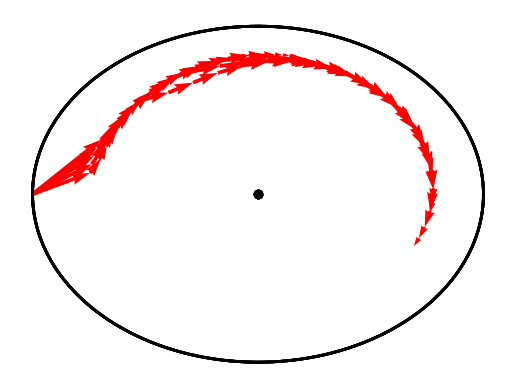

In [ ]:


slam_shift = Light.SlamShift() 
ts = np.arange(0.0, 20*24.0, 0.10)
light_values = slam_shift(ts)
# Run this for a range of period parameters 
spm_model = SinglePopModel({ 'tau': np.linspace(23.5,24.5,5) }) 

initial_state = np.array([1.0, np.pi, 0.0]) + np.zeros((5, 3))
trajectory = spm_model(ts=ts, light_est=light_values, state=initial_state)
ax = plt.gca()
for idx in range(trajectory.batch_size):
    Stroboscopic(ax, 
                ts, 
                trajectory.states[idx, 0, :], 
                trajectory.states[idx, 1, :], 
                period=24.0, 
                lw=0.50,
                color='red');

In [ ]:
#| export

def plot_mae(dlmo_actual: np.ndarray, 
             dlmo_pred: np.ndarray, 
             norm_to: float = None, 
             ax=None,  
             *args, 
             **kwargs):

    dlmo_actual = np.fmod(dlmo_actual, 24.0)
    dlmo_pred = np.fmod(dlmo_pred, 24.0)

    # Make the plot range from from -12 to 12
    dlmo_pred = np.array([cut_phases_12(d) for d in list(dlmo_pred)])
    dlmo_actual = np.array([cut_phases_12(d) for d in list(dlmo_actual)])

    if norm_to is not None:
        dlmo_actual = dlmo_actual - np.mean(dlmo_actual)+norm_to

    if ax is None:
        plt.figure()
        ax = plt.gca()

    errors = dlmo_pred-dlmo_actual
    print(f"The MAE is: {np.mean(abs(errors))}")
    print(f"Within one hour {np.sum(abs(errors)<=1.0)}/{len(dlmo_pred)}")

    print(errors)

    ax.scatter(dlmo_actual, dlmo_pred, *args, **kwargs)
    ax.plot(np.arange(-12, 12, 1), np.arange(-12, 12, 1),
            ls='--', color='gray', lw=2.0)
    ax.plot(np.arange(-12, 12, 1), np.arange(-12, 12, 1)+1,
            ls='--', color='blue', lw=1.0)
    ax.plot(np.arange(-12, 12, 1), np.arange(-12, 12, 1)-1,
            ls='--', color='blue', lw=1.0)

    ax.set_ylabel("Model Prediction (hrs)")
    ax.set_xlabel("Experimental DLMO (hrs)")



In [ ]:
#| export 


def plot_torus(phase1: np.ndarray, 
               phase2: np.ndarray, 
               scale24=False, 
               ax=None, *args, **kwargs):

    if ax is None:
        plt.figure()
        ax = plt.gca()

    if scale24:
        phase1 = np.fmod(phase1, 24.0) * np.pi/12.0
        phase2 = np.fmod(phase2,  24.0) * np.pi/24.0

    phase1 = np.arctan2(np.sin(phase1), np.cos(phase1))
    phase2 = np.arctan2(np.sin(phase2), np.cos(phase2))

    ax.scatter(phase1, phase2, *args, **kwargs)

In [ ]:
# | hide
import nbdev
nbdev.nbdev_export()
